# First stage of Sempli project: Cleaning the data

In [1]:
import pandas as pd
import numpy as np
import json
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import scipy.stats
# Configuración de pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Loading the data

In this part of the project we are loading the excel file and normalizing the json format presented in the columns 'expected_detail' and 'paid_detail'

After normalizing the data we delete rows where the state of the client were 'GRACE' or 'PENDING' because of the COVID situation present at the moment of the study ('GRACE'), and the missing values presented on 'PENDING'

In [2]:
path_file = "loan_schedules.xlsx"
cols = ['client_id',
        'loan_schedule_id',
        'loan_id',
        'index',
        'expected_date',
        'state',
        'arrears_days',
        'paid_date',
        'expected_detail',
        'paid_detail']
data = pd.read_excel(path_file, sheet_name = 1, header = 0, usecols = cols).replace('NaT', np.nan)

def normalize_data(df, col_name):
    data = df[col_name].apply(json.loads)
    return pd.json_normalize(data)

expected = normalize_data(data,'expected_detail')
paid = normalize_data(data,'paid_detail')
data = data.join(expected).join(paid, rsuffix='_paid')
data = data[data.state != "GRACE"]
data = data[data.state != "PENDING"]
data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,expected_detail,paid_detail,total,penalty,interest,insurance,principal,taxRetentionValue,taxRetentionPercentage,fngTotal,fngValue,fngPercent,fngVatValue,legalCharge,fngVatPercent,preLegalCharge,feesPaid,monthlyDeferredInterest,total_paid,penalty_paid,interest_paid,insurance_paid,principal_paid,taxRetentionValue_paid,taxRetentionPercentage_paid,fngTotal_paid,fngValue_paid,fngPercent_paid,fngVatValue_paid,legalCharge_paid,fngVatPercent_paid,preLegalCharge_paid,feesPaid_paid,monthlyDeferredInterest_paid
1,2442,13696,592,6,2019-03-18,PAID,0,2019-03-18,"{""total"": 22872996.50, ""penalty"": 0, ""interest...","{""total"": 22872996.50, ""penalty"": 0, ""interest...",22872996.50,0,358105.48,0.0,22514891.02,14324.2192,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22872996.50,0,358105.48,0,22514891.02,0,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9273,43776,1831,3,2020-03-04,PAID,5,2020-03-09,"{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...","{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...",7322168.42,0,3015180.80,59878.0,4306987.62,120607.2320,0.04,0.0,0.0,0.028,0.0,NaN,0.19,NaN,NaN,NaN,7322168.42,0,3015180.80,0,4306987.62,0,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Deleting unnecessary columns

After taking a look at the data, we came to the conclusion to use total_paid and total_expected values and delete the other variable presented on 'data_droped_columns'

In [3]:
data_droped_columns = ['penalty', 'interest', 'insurance', 'principal', 'taxRetentionValue',
                       'taxRetentionPercentage', 'legalCharge', 'preLegalCharge', 'feesPaid',
                       'fngTotal', 'fngValue',
                       'fngPercent', 'fngVatValue', 'fngVatPercent', 'monthlyDeferredInterest',
                       'penalty_paid', 'interest_paid', 'insurance_paid',
                       'principal_paid', 'taxRetentionValue_paid',
                       'taxRetentionPercentage_paid', 'legalCharge_paid',
                       'preLegalCharge_paid', 'feesPaid_paid', 'fngTotal_paid',
                       'fngValue_paid', 'fngPercent_paid', 'fngVatValue_paid',
                       'fngVatPercent_paid', 'monthlyDeferredInterest_paid']
data = data.drop(columns=data_droped_columns)
data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,expected_detail,paid_detail,total,total_paid
1,2442,13696,592,6,2019-03-18,PAID,0,2019-03-18,"{""total"": 22872996.50, ""penalty"": 0, ""interest...","{""total"": 22872996.50, ""penalty"": 0, ""interest...",22872996.50,22872996.50
2,9273,43776,1831,3,2020-03-04,PAID,5,2020-03-09,"{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...","{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...",7322168.42,7322168.42


### checking normalized values
After deleting the some columns, we check if the 'total' and 'total_paid' match to the one on 'expected_detail' for 'total' and 'paid_detail' for 'total_paid'

The next step is delete the rows with json format and organize the data by 'client_id'

In [4]:
unused_columns = ['expected_detail', 'paid_detail']
data = data.drop(columns=unused_columns)
data = data.sort_values(by='client_id', ascending=True)
data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid
7924,14,79,14,5,2017-09-27,PAID,0,2017-09-27,1497723.06,1497723.06
5477,14,77,14,3,2017-07-27,PAID,0,2017-07-27,1497723.06,1497723.06


### Analyzing by loan ID 

At this stage we agreed to analyze how's the payment by loan_id on the last 6 months

In [5]:
data = data.sort_values(['client_id', 'loan_id', 'expected_date'])
data = data.groupby('loan_id').filter(lambda x : x['loan_id'].value_counts() > 6).groupby('loan_id').tail(6)
data.head(10)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid
5677,14,80,14,6,2017-10-27,PAID,4,2017-10-31,1497723.06,1497723.06
860,14,81,14,7,2017-11-27,PAID,0,2017-11-27,1499416.03,1499416.03
861,14,82,14,8,2017-12-27,PAID,0,2017-12-27,1497723.06,1497723.06
862,14,83,14,9,2018-01-29,PAID,0,2018-01-29,1497723.06,1497723.06
863,14,84,14,10,2018-02-27,PAID,0,2018-02-08,20078872.73,20078872.73
233,14,85,14,11,2018-03-27,PAID,0,2018-02-09,20018.84,20018.84
3742,141,2863,200,11,2019-08-26,PAID,0,2019-08-26,30141765.76,30141765.76
3743,141,2864,200,12,2019-09-25,PAID,0,2019-09-25,661183.89,661183.89
4954,141,2865,200,13,2019-10-25,PAID,0,2019-10-25,661183.89,661183.89
4956,141,2866,200,14,2019-11-25,PAID,0,2019-11-25,661183.89,661183.89


### Ploting the state behaviour of the clients

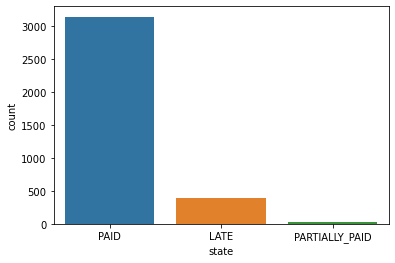

In [6]:
sns.countplot(x='state', data= data)

## Export data dataframe to an excel file

In [7]:
#data.to_excel('output.xlsx')

### Loading cathegorical data

In [8]:
path_file = "data_sempli_holberton.xlsx"
cat_cols = ['ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo',
       'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo',
       'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Tiempo en el negocio',
       'Website empresa', 'Instagram empresa', 'LinkedIn empresa',
       'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas',
       'Impacto', 'Acceso previso a la banca', '# Empleados',
       'Mujeres empresarias', 'Mujeres en cargos directivos']
cat_data = pd.read_excel(path_file, sheet_name = 0, header = 2, usecols = cat_cols).replace('NaT', np.nan)
cat_data.head(3)

,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,7154.0,100000000,SP,25 a 36 meses,Industria,Scale Up,Medellín,4,Sí procesos judiciales,Sí Alertas,909,8,1987,Si website,Si Ig,No LinkedIn,Si LinkedIn empresarios,57,Referrer,8,No Impacto,Si acceso a la banca,77,Si mujeres empresarias,3
1,646.0,320000000,KT - CO,Menos de 12 meses,Servicios,Scale Up,Medellín,4,No procesos judiciales,No Alertas,937,0,1987,Si website,No Ig,No LinkedIn,Si LinkedIn empresarios,36,Other,3,No Impacto,Si acceso a la banca,35,No mujeres empresarias,2
2,3934.0,300000000,SP,25 a 36 meses,Servicios,Scale Up,Medellín,5,No procesos judiciales,No Alertas,933,11,1992,Si website,Si Ig,No LinkedIn,No LinkedIn empresarios,46,Other,5,No Impacto,No acceso a la banca,60,No mujeres empresarias,3


In [9]:
cat_data = cat_data.sort_values(by='ID Cliente', ascending=True)
cat_data.head(2)

,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
269,98.0,30000000,KT - EX,13 a 24 meses,Servicios,Venture,Bogotá D.C.,5,No procesos judiciales,No Alertas,0,0,2013,No website,No Ig,No LinkedIn,No LinkedIn empresarios,30,Internet,1,Si Impacto,Si acceso a la banca,110,No mujeres empresarias,3
529,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No procesos judiciales,No Alertas,925,8,2016,Si website,Si Ig,Si LinkedIn,Si LinkedIn empresarios,45,Internet,2,No Impacto,Si acceso a la banca,16,No mujeres empresarias,2


In [10]:
rep_columns = ['Procesos judiciales', 'Alertas', 'Website empresa',
               'Instagram empresa', 'LinkedIn empresa',
               'LinkedIn empresarios', 'Impacto', 'Acceso previso a la banca',
               'Mujeres empresarias']

cat_data[rep_columns] = cat_data[rep_columns].replace({'No procesos judiciales':'No',
                                                           'Sí procesos judiciales':'Si',
                                                           'No Alertas':'No',
                                                           'Sí Alertas': 'Si',
                                                           'No website':'No',
                                                           'Si website':'Si',
                                                           'No Ig':'No',
                                                           'Si Ig':'Si',
                                                           'No LinkedIn':'No',
                                                           'Si LinkedIn':'Si',
                                                           'No LinkedIn empresarios':'No',
                                                           'Si LinkedIn empresarios':'Si',
                                                           'Si Impacto':'Si',
                                                           'No Impacto':'No',
                                                           'Si acceso a la banca':'Si',
                                                           'No acceso a la banca':'No',
                                                           'No mujeres empresarias':'No',
                                                           'Si mujeres empresarias':'Si'})
cat_data.head(2)

,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
269,98.0,30000000,KT - EX,13 a 24 meses,Servicios,Venture,Bogotá D.C.,5,No,No,0,0,2013,No,No,No,No,30,Internet,1,Si,Si,110,No,3
529,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,2016,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2


In [11]:
clean_data = pd.DataFrame()
clean_data = data.merge(cat_data, left_on='client_id', right_on='ID Cliente')
clean_data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,241,25718,1076,8,2019-08-14,PAID,16,2019-08-30,5947504.88,5947504.88,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,2016,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2
1,241,25719,1076,9,2019-09-16,PAID,1,2019-09-17,5972929.73,5972929.73,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,2016,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2


In [12]:
clean_data.shape

(3492, 35)

## Data Analysis

In [13]:
clean_data.isnull().any()

client_id                       False
loan_schedule_id                False
loan_id                         False
index                           False
expected_date                   False
state                           False
arrears_days                    False
paid_date                        True
total                           False
total_paid                      False
ID Cliente                      False
Monto Acumulado                 False
Uso de los recursos             False
Plazo                           False
Sector                          False
Ingresos                        False
Ubicación                       False
Estrato Mínimo                  False
Procesos judiciales             False
Alertas                         False
Score Bureau Empresa            False
Huellas de Consulta             False
Tiempo en el negocio            False
Website empresa                 False
Instagram empresa               False
LinkedIn empresa                False
LinkedIn emp

In [14]:
clean_data['paid_date'].isnull().value_counts()/len(clean_data)

False    0.906644
True     0.093356
Name: paid_date, dtype: float64

In [15]:
len(clean_data)

3492

In [16]:
clean_data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,241,25718,1076,8,2019-08-14,PAID,16,2019-08-30,5947504.88,5947504.88,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,2016,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2
1,241,25719,1076,9,2019-09-16,PAID,1,2019-09-17,5972929.73,5972929.73,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,2016,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2


#### Analizing Cathegorical data

Text(0.5, 0.98, 'Frecuency of observation by Sector')

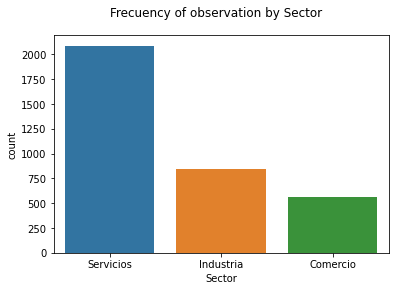

In [17]:
sns.countplot(x='Sector', data = clean_data)
plt.suptitle('Frecuency of observation by Sector')

The mayority of companies are from the 'Servicios' sector. Here you can see that there are way more companies from the 'Servicios' sector than from the 'Industria' and 'Comercio'

Text(0.5, 0.98, 'Frecuency of obervation by Activador')

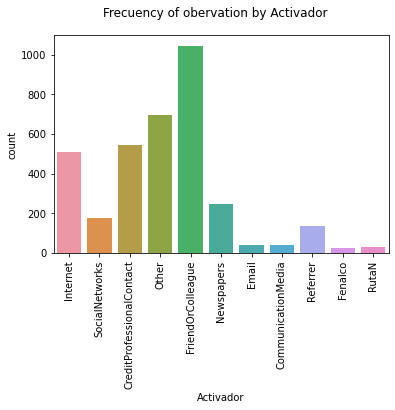

In [18]:
act_graph = sns.countplot(x='Activador', data = clean_data)
act_graph.set_xticklabels(act_graph.get_xticklabels(), rotation=90)
plt.suptitle('Frecuency of obervation by Activador')

Text(0.5, 0.98, 'Frecuency of obervation by -Procesos Judiciales-')

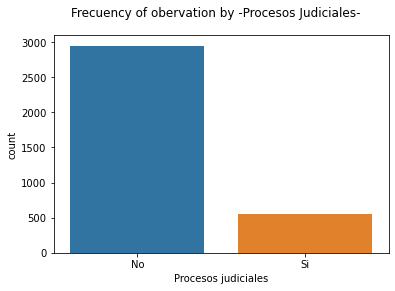

In [19]:
sns.countplot(x='Procesos judiciales', data = clean_data)
plt.suptitle('Frecuency of obervation by -Procesos Judiciales-')

Text(0.5, 0.98, 'Frecuency of obervation by -Ubicación-')

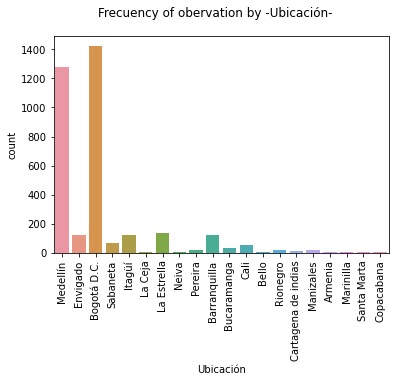

In [20]:
ubc_graph = sns.countplot(x='Ubicación', data = clean_data)
ubc_graph.set_xticklabels(ubc_graph.get_xticklabels(), rotation=90)
plt.suptitle('Frecuency of obervation by -Ubicación-')

Text(0.5, 0.98, 'Frecuency of observation by Ingresos')

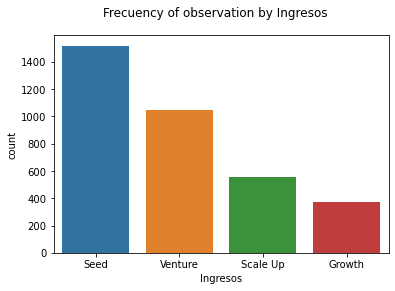

In [21]:
sns.countplot(x='Ingresos', data = clean_data)
plt.suptitle('Frecuency of observation by Ingresos')

Text(0.5, 0.98, 'Frecuency of observation by Uso de los recursos')

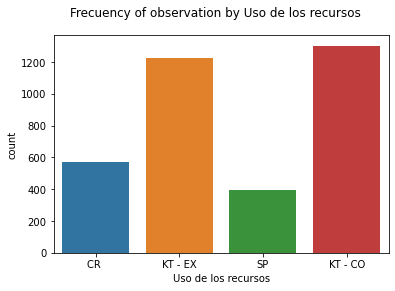

In [22]:
sns.countplot(x='Uso de los recursos', data = clean_data)
plt.suptitle('Frecuency of observation by Uso de los recursos')

Text(0.5, 0.98, 'Frecuency of observation by Instagram empresa')

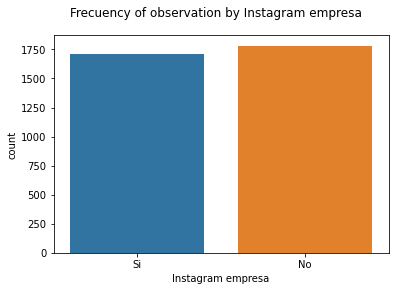

In [23]:
sns.countplot(x='Instagram empresa', data = clean_data)
plt.suptitle('Frecuency of observation by Instagram empresa')

Text(0.5, 0.98, 'Frecuency of observation by Website empresa')

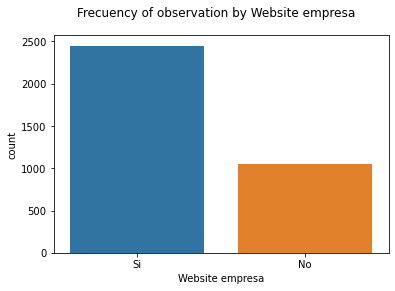

In [24]:
sns.countplot(x='Website empresa', data = clean_data)
plt.suptitle('Frecuency of observation by Website empresa')

Text(0.5, 0.98, 'Frecuency of observation by LinkedIn empresa')

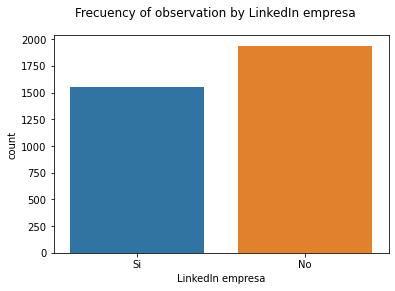

In [25]:
sns.countplot(x='LinkedIn empresa', data = clean_data)
plt.suptitle('Frecuency of observation by LinkedIn empresa')

Text(0.5, 0.98, 'Frecuency of observation by LinkedIn empresarios')

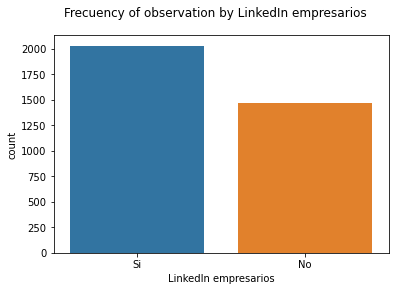

In [26]:
sns.countplot(x='LinkedIn empresarios', data = clean_data)
plt.suptitle('Frecuency of observation by LinkedIn empresarios')

#### Analizing Numerical data

In [27]:
clean_data['total_paid'].describe()

count    3.492000e+03
mean     6.726129e+06
std      1.211232e+07
min      0.000000e+00
25%      2.173250e+06
50%      3.876377e+06
75%      7.504030e+06
max      2.152136e+08
Name: total_paid, dtype: float64

Text(0.5, 0.98, 'Distribution of total_paid')

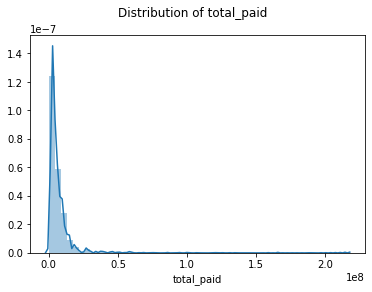

In [28]:
sns.distplot(clean_data['total_paid'])
plt.suptitle('Distribution of total_paid')

In [29]:
clean_data['total'].describe()

count    3.492000e+03
mean     7.273342e+06
std      1.199799e+07
min      1.122284e+04
25%      2.644683e+06
50%      4.621523e+06
75%      7.673561e+06
max      2.152136e+08
Name: total, dtype: float64

Text(0.5, 0.98, 'Distribution of total expected')

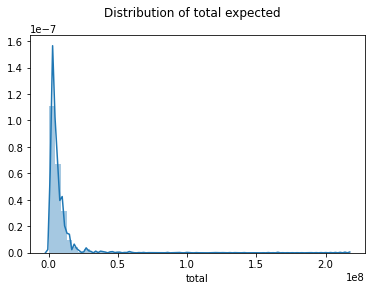

In [30]:
sns.distplot(clean_data['total'])
plt.suptitle('Distribution of total expected')

In [31]:
clean_data['arrears_days'].describe()

count    3492.000000
mean       11.796678
std        26.780956
min         0.000000
25%         0.000000
50%         1.000000
75%        11.000000
max       258.000000
Name: arrears_days, dtype: float64

Text(0.5, 0.98, 'Distribution of arrears_days')

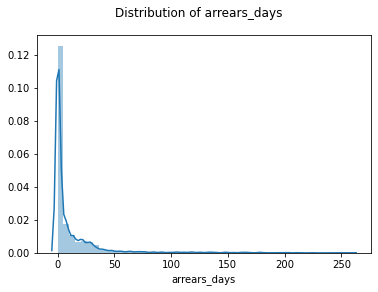

In [32]:
sns.distplot(clean_data['arrears_days'])
plt.suptitle('Distribution of arrears_days')

In [33]:
clean_data.columns

Index(['client_id', 'loan_schedule_id', 'loan_id', 'index', 'expected_date', 'state', 'arrears_days', 'paid_date', 'total', 'total_paid', 'ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Tiempo en el negocio', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

In [34]:
clean_data['Huellas de Consulta'].describe()

count     3492
unique      34
top          2
freq       522
Name: Huellas de Consulta, dtype: int64

In [35]:
### Huellas de Consulta: Some rows are -SIN INFO-
# convertirlos a nan
# convertirlos en la media
# Borrarlos

In [36]:
## clean_data[clean_data['Huellas de Consulta'] == 'SIN INFO']

In [37]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3492 entries, 0 to 3491
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   client_id                     3492 non-null   int64         
 1   loan_schedule_id              3492 non-null   int64         
 2   loan_id                       3492 non-null   int64         
 3   index                         3492 non-null   int64         
 4   expected_date                 3492 non-null   datetime64[ns]
 5   state                         3492 non-null   object        
 6   arrears_days                  3492 non-null   int64         
 7   paid_date                     3166 non-null   datetime64[ns]
 8   total                         3492 non-null   float64       
 9   total_paid                    3492 non-null   float64       
 10  ID Cliente                    3492 non-null   float64       
 11  Monto Acumulado               

In [38]:
clean_data['Edad empresarios'].describe()

count    3492.000000
mean       41.056701
std        10.115160
min        22.000000
25%        33.000000
50%        40.000000
75%        46.000000
max        74.000000
Name: Edad empresarios, dtype: float64

Text(0.5, 0.98, 'Distribution of -Edad empresarios-')

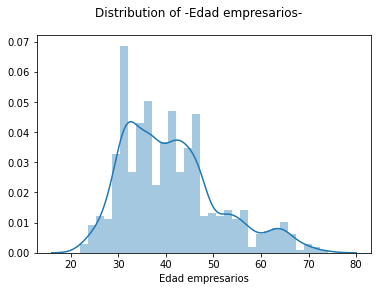

In [39]:
sns.distplot(clean_data['Edad empresarios'])
plt.suptitle('Distribution of -Edad empresarios-')

In [40]:
clean_data['Mujeres en cargos directivos'].describe()

count    3492.000000
mean        1.939863
std         2.524096
min         0.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        25.000000
Name: Mujeres en cargos directivos, dtype: float64

Text(0.5, 0.98, 'Distribution of -Mujeres en cargos directivos-')

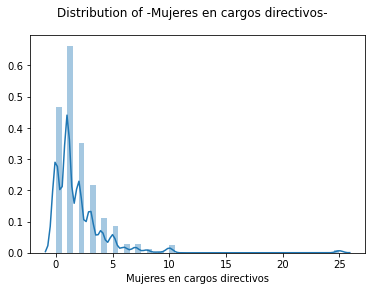

In [41]:
sns.distplot(clean_data['Mujeres en cargos directivos'])
plt.suptitle('Distribution of -Mujeres en cargos directivos-')

In [42]:
clean_data['# Empleados'].describe()

count    3492.000000
mean       26.627148
std        44.749702
min         1.000000
25%         8.000000
50%        13.000000
75%        27.000000
max       500.000000
Name: # Empleados, dtype: float64

Text(0.5, 0.98, 'Distribution of -# Empleados-')

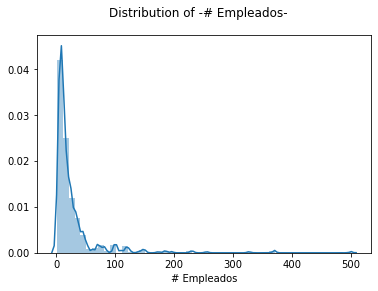

In [43]:
sns.distplot(clean_data['# Empleados'])
plt.suptitle('Distribution of -# Empleados-')

#### Analizing two variables

Text(0.5, 0.98, 'Ingresos vs total_paid')

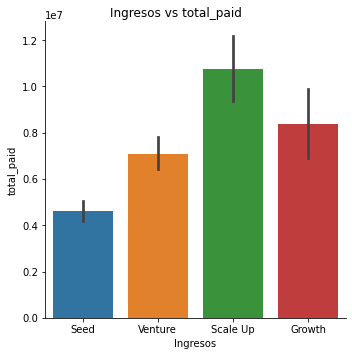

In [44]:
sns.catplot(x='Ingresos', y='total_paid', kind='bar', data=clean_data)
plt.suptitle('Ingresos vs total_paid')

Text(0.5, 0.98, 'Ingresos vs arrears_days')

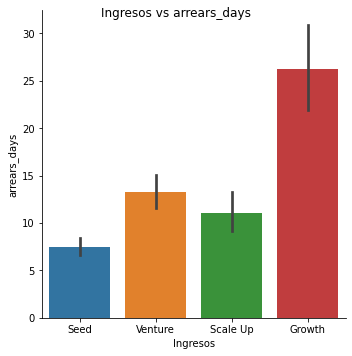

In [45]:
sns.catplot(x='Ingresos', y='arrears_days', kind='bar', data=clean_data)
plt.suptitle('Ingresos vs arrears_days')

Text(0.5, 0.98, 'Sector vs arrears_days')

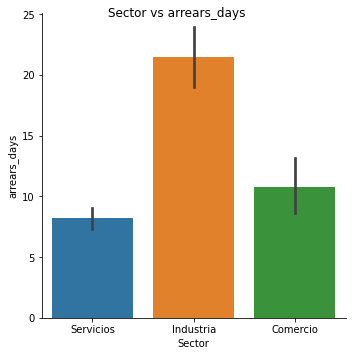

In [46]:
sns.catplot(x='Sector', y='arrears_days', kind='bar', data=clean_data)
plt.suptitle('Sector vs arrears_days')

Text(0.5, 0.98, 'Sector vs total_paid')

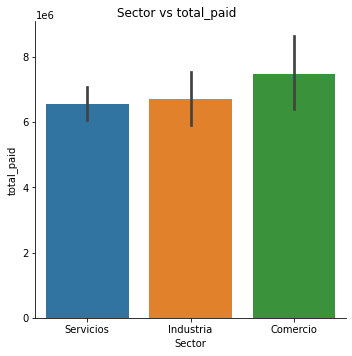

In [47]:
sns.catplot(x='Sector', y='total_paid', kind='bar', data=clean_data)
plt.suptitle('Sector vs total_paid')

##### Q - Q

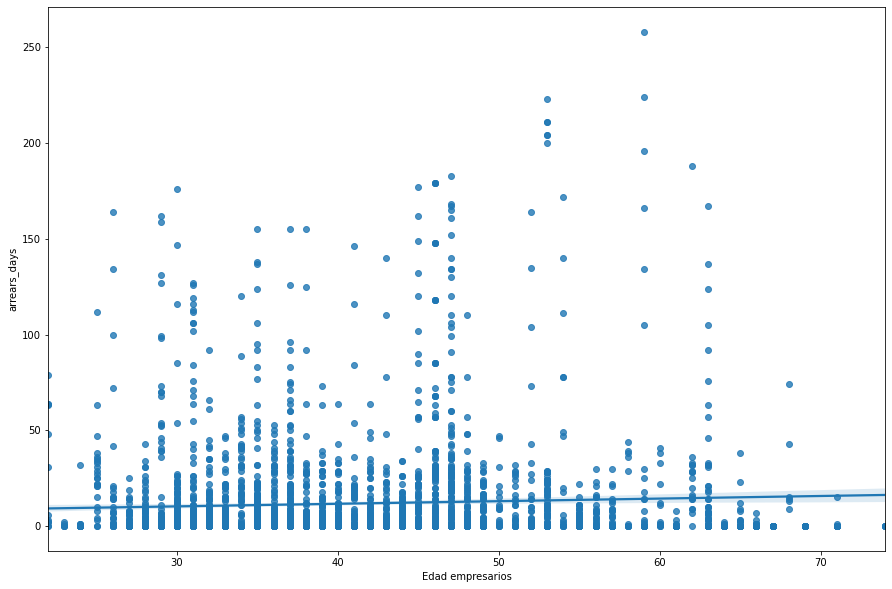

In [48]:
plt.figure(figsize=(15,10))
sns.regplot(x='Edad empresarios', y='arrears_days', data=clean_data)
plt.show()

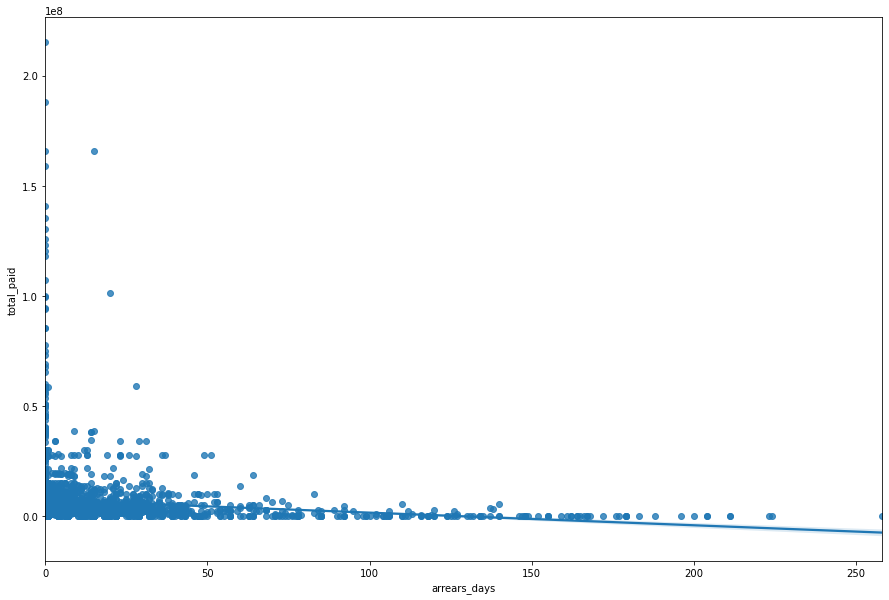

In [49]:
plt.figure(figsize=(15,10))
sns.regplot(y='total_paid', x='arrears_days', data=clean_data)
plt.show()

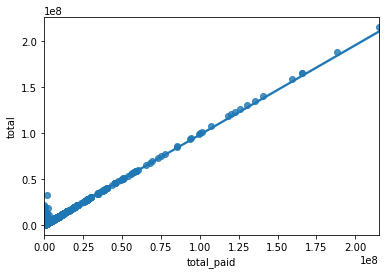

In [50]:
sns.regplot(x='total_paid', y='total', data=clean_data)

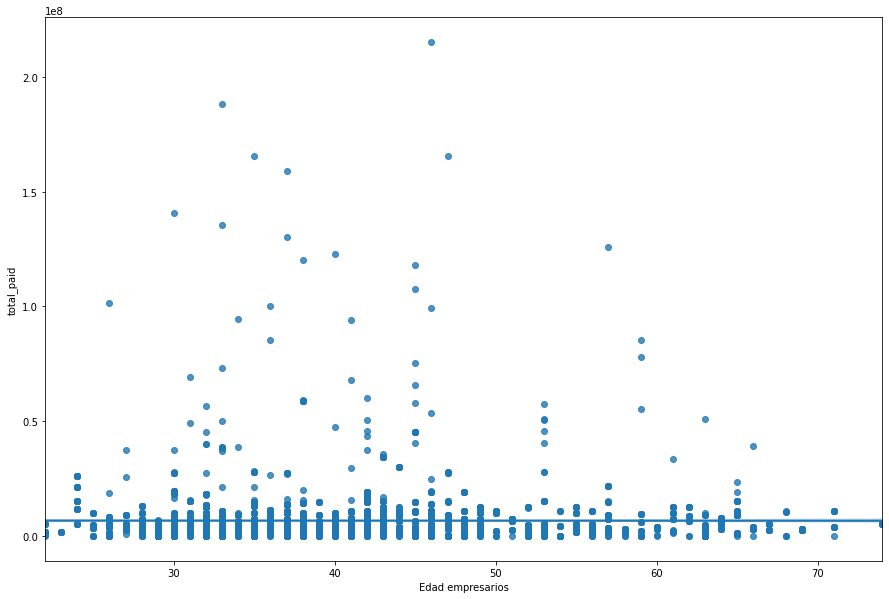

In [51]:
plt.figure(figsize=(15,10))
sns.regplot(x='Edad empresarios', y='total_paid', data=clean_data)
plt.show()

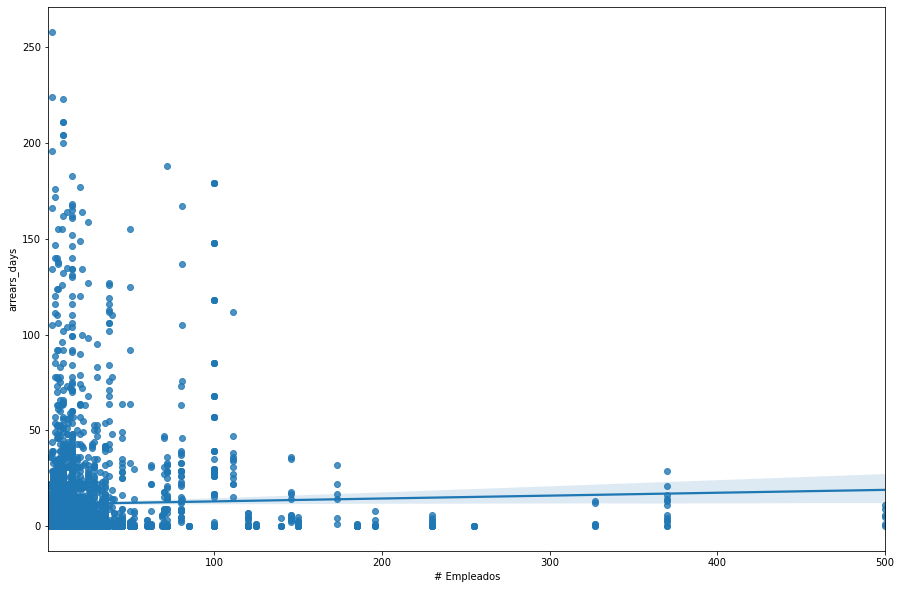

In [52]:
plt.figure(figsize=(15,10))
sns.regplot(x='# Empleados', y='arrears_days', data=clean_data)
plt.show()

#### C - C

In [53]:
clean_data.groupby('Ingresos')['Uso de los recursos'].value_counts()/len(clean_data)

Ingresos  Uso de los recursos
Growth    KT - CO                0.039519
          KT - EX                0.037801
          CR                     0.029210
Scale Up  KT - CO                0.070447
          KT - EX                0.058419
          CR                     0.022337
          SP                     0.008591
Seed      KT - EX                0.147766
          KT - CO                0.135739
          SP                     0.077320
          CR                     0.073883
Venture   KT - CO                0.127148
          KT - EX                0.106529
          CR                     0.037801
          SP                     0.027491
Name: Uso de los recursos, dtype: float64

In [54]:
clean_data.groupby('Ubicación')['Activador'].value_counts()/len(clean_data)

Ubicación            Activador                
Armenia              Other                        0.001718
Barranquilla         Other                        0.013746
                     CreditProfessionalContact    0.005155
                     Internet                     0.005155
                     Newspapers                   0.005155
                     Referrer                     0.005155
                     FriendOrColleague            0.001718
Bello                SocialNetworks               0.001718
Bogotá D.C.          FriendOrColleague            0.151203
                     Internet                     0.096220
                     Other                        0.048110
                     Newspapers                   0.037801
                     CreditProfessionalContact    0.029210
                     SocialNetworks               0.017182
                     Referrer                     0.013746
                     CommunicationMedia           0.010309
         

In [55]:
clean_data.groupby('Sector')['Ingresos'].value_counts()/len(clean_data)

Sector     Ingresos
Comercio   Seed        0.054983
           Venture     0.049828
           Growth      0.029210
           Scale Up    0.027491
Industria  Venture     0.087629
           Seed        0.070447
           Growth      0.041237
           Scale Up    0.041237
Servicios  Seed        0.309278
           Venture     0.161512
           Scale Up    0.091065
           Growth      0.036082
Name: Ingresos, dtype: float64

In [56]:
clean_data.groupby('Sector')['Uso de los recursos'].value_counts()/len(clean_data)

Sector     Uso de los recursos
Comercio   KT - CO                0.108247
           KT - EX                0.024055
           CR                     0.022337
           SP                     0.006873
Industria  KT - CO                0.073883
           KT - EX                0.070447
           CR                     0.054983
           SP                     0.041237
Servicios  KT - EX                0.256014
           KT - CO                0.190722
           CR                     0.085911
           SP                     0.065292
Name: Uso de los recursos, dtype: float64

In [57]:
clean_data.columns

Index(['client_id', 'loan_schedule_id', 'loan_id', 'index', 'expected_date', 'state', 'arrears_days', 'paid_date', 'total', 'total_paid', 'ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Tiempo en el negocio', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

In [58]:
clean_data.groupby('arrears_days').describe()

client_id                                                                     loan_schedule_id                                                                            loan_id                                                                      index                                                         total                                                                                                  total_paid                                                                                                 ID Cliente                                                                     Monto Acumulado                                                                                                   Estrato Mínimo                                                Tiempo en el negocio                                                                   Edad empresarios                                                       # Empleados                                        \
                 count         mean          std     min      25%     50%      75%     max            count          mean           std      min       25%      50%       75%      max   count         mean         std     min      25%     50%      75%     max   count       mean        std   min    25%   50%    75%   max   count          mean           std          min           25%           50%           75%           max      count          mean           std         min           25%           50%           75%           max      count         mean          std     min      25%     50%      75%     max           count          mean           std           min           25%           50%           75%           max          count      mean       std  min   25%  50%   75%  max                count         mean        std     min      25%     50%      75%     max            count       mean        std   min    25%   50%    75%   max       count        mean        std    min     25%   
arrears_days                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
0               1561.0  2613.005766  1615.552125   241.0  1467.00  2440.0  3780.00  7279.0           1561.0  23381.361307  10088.623567     58.0  15435.00  26764.0  31343.00  37873.0  1561.0   993.963485  414.796812    11.0   667.00  1132.0  1324.00  1600.0  1561.0   9.675849   5.308434   2.0   6.00   9.0  12.00  36.0  1561.0  8.745294e+06  1.612637e+07     11222.84  2.644683e+06  4.632683e+06  9.118363e+06  2.152136e+08     1561.0  8.630071e+06  1.613504e+07     6207.77  2.573706e+06  4.604012e+06  9.069265e+06  2.152136e+08     1561.0  2613.005766  1615.552125   241.0  1467.00  2440.0  3780.00  7279.0          1561.0  3.058394e+08  2.922578e+08  3.000000e+07  1.100000e+08  2.000000e+08  3.800000e+08  1.299371e+09         1561.0  4.629084  0.976073  2.0  4.00  5.0  5.00  6.0               1561.0  2010.421525   7.743676  1958.0  2009.00  2013.0  2015.00  2018.0           1561.0  41.368354  10.694691  22.0  33.00  40.0  45.00  74.0      1561.0   25.550929  40.218428    1.0    7.00   
1                314.

In [59]:
clean_data.groupby('arrears_days').corr()

client_id  loan_schedule_id   loan_id     index     total  total_paid  ID Cliente  Monto Acumulado  Estrato Mínimo  Tiempo en el negocio  Edad empresarios  # Empleados  Mujeres en cargos directivos
arrears_days                                                                                                                                                                                                                                    
0            client_id                      1.000000          0.537484  0.543245 -0.373945 -0.116450   -0.115883    1.000000        -0.377429       -0.149067              0.039507          0.075076    -0.015302                      0.025550
             loan_schedule_id               0.537484          1.000000  0.999196 -0.547129 -0.128083   -0.126893    0.537484        -0.341185       -0.157858              0.088677          0.059065    -0.035361                     -0.001985
             loan_id                        0.543245          0.999196  1.000000 -0.549393 -0.128719   -0.127509    0.543245        -0.342067       -0.156539              0.092396          0.056768    -0.035703                     -0.001708
             index                         -0.373945         -0.547129 -0.549393  1.000000  0.068962    0.068243   -0.373945         0.203434        0.118683              0.011607         -0.024148     0.021873                     -0.053189
             total                         -0.116450         -0.128083 -0.128719  0.068962  1.000000    0.997109   -0.116450         0.252290        0.063824             -0.094291          0.002085     0.126459                      0.054467
...                                              ...               ...       ...       ...       ...         ...         ...              ...             ...                   ...               ...          ...                           ...
258          Estrato Mínimo                      NaN               NaN       NaN       NaN       NaN         NaN         NaN              NaN             NaN                   NaN               NaN          NaN                           NaN
             Tiempo en el negocio                NaN               NaN       NaN       NaN       NaN         NaN         NaN              NaN             NaN                   NaN               NaN          NaN                           NaN
             Edad empresarios                    NaN               NaN       NaN       NaN       NaN         NaN         NaN              NaN             NaN                   NaN               NaN          NaN                           NaN
             # Empleados                         NaN               NaN       NaN       NaN       NaN         NaN         NaN              NaN             NaN                   NaN               NaN          NaN                           NaN
             Mujeres en cargos directivos        NaN               NaN       NaN       NaN       NaN         NaN         NaN              NaN             NaN                   NaN               NaN          NaN                           NaN

[1807 rows x 13 columns]

In [60]:
clean_data_copy = clean_data.copy()

In [61]:
# Inferencial statistics

# Hypothesis testing:
# 1. define null hypothesis and alternate hypothesis
# 2. Choose sample
# 3. Analyse evidence
# 4. Interpret results

# H0: There is no relationship between the explanatory and response 
# H1: There is a statistically significant relationship

# Bivariate statistical tools:
# Anova; chi-square; correlation coefficient 

In [62]:
# Explanatory cathegorical and response quantitative: ANOVA
# Explanatory cathegorical and response cathegorical: Chi Square test
# Explanatory quantitative and response cathegorical: classify/bin explanatory
# Explanatory quantitative and response quantitative: Pearson correlation

In [63]:
# ANOVA table
test1 = smf.ols(formula = 'arrears_days ~ C(Sector)', data=clean_data_copy).fit()
print(test1.summary())

                            OLS Regression Results                            
Dep. Variable:           arrears_days   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     77.48
Date:                Sat, 03 Oct 2020   Prob (F-statistic):           1.20e-33
Time:                        18:51:07   Log-Likelihood:                -16359.
No. Observations:                3492   AIC:                         3.272e+04
Df Residuals:                    3489   BIC:                         3.274e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 10

In [64]:
# Now we check mean and stardard deviation
grouped1_mean = clean_data_copy.groupby('Sector').mean()['arrears_days']
print(grouped1_mean)

Sector
Comercio     10.750000
Industria    21.472619
Servicios     8.186782
Name: arrears_days, dtype: float64


In [65]:
grouped1_std = clean_data_copy.groupby('Sector').std()['arrears_days']
print(grouped1_std)

Sector
Comercio     27.901684
Industria    37.984806
Servicios    18.937989
Name: arrears_days, dtype: float64


In [66]:
tuckey1 = multi.MultiComparison(clean_data_copy['arrears_days'], clean_data_copy['Sector'])
res1 = tuckey1.tukeyhsd()
print(res1.summary())

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1    group2  meandiff p-adj   lower    upper   reject
------------------------------------------------------------
 Comercio Industria  10.7226  0.001   7.3767  14.0685   True
 Comercio Servicios  -2.5632 0.0983  -5.4799   0.3535  False
Industria Servicios -13.2858  0.001 -15.7971 -10.7746   True
------------------------------------------------------------


In [67]:
# Second Hypothesis
test2 = smf.ols(formula = 'arrears_days ~ C(Ingresos)', data=clean_data_copy).fit()
print(test2.summary())

                            OLS Regression Results                            
Dep. Variable:           arrears_days   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     52.93
Date:                Sat, 03 Oct 2020   Prob (F-statistic):           1.88e-33
Time:                        18:51:07   Log-Likelihood:                -16357.
No. Observations:                3492   AIC:                         3.272e+04
Df Residuals:                    3488   BIC:                         3.275e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [68]:
# Now we check mean and stardard deviation
grouped2_mean = clean_data_copy.groupby('Ingresos').mean()['arrears_days']
print(grouped2_mean)

Ingresos
Growth      26.279570
Scale Up    11.093190
Seed         7.473650
Venture     13.297893
Name: arrears_days, dtype: float64


In [69]:
grouped2_std = clean_data_copy.groupby('Ingresos').std()['arrears_days']
print(grouped2_std)

Ingresos
Growth      45.356656
Scale Up    23.735116
Seed        16.549688
Venture     29.412143
Name: arrears_days, dtype: float64


In [70]:
tuckey2 = multi.MultiComparison(clean_data_copy['arrears_days'], clean_data_copy['Ingresos'])
res2 = tuckey2.tukeyhsd()
print(res2.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
  Growth Scale Up -15.1864  0.001 -19.6943 -10.6785   True
  Growth     Seed -18.8059  0.001 -22.7022 -14.9097   True
  Growth  Venture -12.9817  0.001 -17.0483  -8.9151   True
Scale Up     Seed  -3.6195 0.0272  -6.9537  -0.2854   True
Scale Up  Venture   2.2047 0.3771   -1.327   5.7364  False
    Seed  Venture   5.8242  0.001   3.1164   8.5321   True
----------------------------------------------------------


In [71]:
# -------------------------------------------------------------

In [72]:
norm_data = pd.DataFrame()
cat_cols = ['ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo',
       'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo',
       'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Tiempo en el negocio',
       'Website empresa', 'Instagram empresa', 'LinkedIn empresa',
       'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas',
       'Impacto', 'Acceso previso a la banca', '# Empleados',
       'Mujeres empresarias', 'Mujeres en cargos directivos']
norm_data = clean_data.drop(columns=cat_cols)

In [73]:
#norm_data.to_excel('six_loan_id.xlsx')

In [74]:
norm_data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid
0,241,25718,1076,8,2019-08-14,PAID,16,2019-08-30,5947504.88,5947504.88
1,241,25719,1076,9,2019-09-16,PAID,1,2019-09-17,5972929.73,5972929.73


In [75]:
norm_data['loan_id'].value_counts()

1595    6
1328    6
1264    6
1262    6
1260    6
       ..
971     6
903     6
839     6
837     6
20      6
Name: loan_id, Length: 582, dtype: int64

In [76]:
info = clean_data.corr()

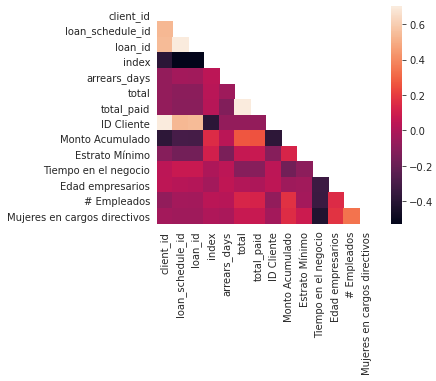

In [77]:
mask=np.zeros_like(info,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style("white"):
    a=sns.heatmap(info,mask=mask,vmax=0.7,square=True)